In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import re
import warnings
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K
from PIL import Image
import pickle
from rembg import remove

# Test shit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.applications.mobilenet import MobileNet
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

2023-04-15 07:28:12.997275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
warnings.filterwarnings("ignore")

In [8]:
def set_seed(seed):
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [9]:
set_seed(42)

In [10]:
image_dir = '../dataset/splited/shark_44/train'
test_dir = '../dataset/splited/shark_44/test'

In [ ]:
def load_img(image_dir):
    list_images = []
    for label in os.listdir(image_dir):
        if label != '.DS_Store':
            for file in os.listdir(os.path.join(image_dir,label)):
                if re.search('jpg|JPG', file):
                    list_images.append(f"{image_dir}/{label}/{file}")
    return list_images

In [11]:
def extract_feature(list_images):
    features = []
    labels = []

    nb_features = 1920  
    features = np.empty((len(list_images), nb_features))

    for ind, image_path in enumerate(list_images):
        print('Processing %s...' % (image_path))
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features[ind,:] = np.squeeze(extractor_model.predict(x))
        labels.append(image_path.split('/')[-2])
    
    return features, labels

# DenseNet as feature extractor

In [12]:
base_model = DenseNet201(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
extractor_model = Model(inputs=base_model.input, outputs=x)

In [ ]:
train_images = load_img(image_dir)
features, labels = extract_feature(train_images)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(features, labels_numeric, test_size=0.1, random_state=42)
smote = SMOTE(random_state=42, k_neighbors = 3)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
test_img = load_img(test_dir)
X_test, y_test = extract_feature(test_img)

In [ ]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

In [ ]:
pickle.dump(features, open('test_features', 'wb'))
pickle.dump(labels, open('test_labels', 'wb'))

In [13]:
with open('features', 'rb') as f:
    features = pickle.load(f)

# Load labels
with open('labels', 'rb') as f:
    labels = pickle.load(f)

In [14]:
with open('test_features', 'rb') as f:
    X_test = pickle.load(f)

# Load labels
with open('test_labels', 'rb') as f:
    y_test = pickle.load(f)

In [15]:
# Number of labels - 18
class_labels = os.listdir(image_dir)
if '.DS_Store' in class_labels:
    class_labels.remove('.DS_Store')
encoder_labels = LabelEncoder()
encoder_labels.fit(class_labels)
labels_numeric = encoder_labels.transform(labels)

In [16]:
y_test_label = encoder_labels.transform(y_test)

In [ ]:
sorted(class_labels)

# ANN

In [ ]:
ann_classifier = Sequential()
ann_classifier.add(Dense(1024, activation='relu', input_shape=(1920,)))
ann_classifier.add(Dropout(0.2))
ann_classifier.add(Dense(512, activation='relu'))
ann_classifier.add(Dropout(0.2))
ann_classifier.add(Dense(256, activation='relu'))
ann_classifier.add(Dropout(0.2))
ann_classifier.add(Dense(128, activation='relu'))
ann_classifier.add(Dense(18, activation='softmax'))

ann_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = ann_classifier.fit(X_train, to_categorical(y_train), epochs=20, 
                             batch_size=32,
                             validation_data=(X_val, to_categorical(y_val)))

test_loss, test_acc = ann_classifier.evaluate(X_test, to_categorical(y_test_label, num_classes=18))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
ann_classifier.save('../model/ann_model.h5')

# CNN

In [29]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape

cnn_classifier = Sequential()
cnn_classifier.add(Conv1D(64, 3, activation='relu', input_shape=(1920, 1)))
cnn_classifier.add(MaxPooling1D(2))
cnn_classifier.add(Conv1D(32, 3, activation='relu'))
cnn_classifier.add(MaxPooling1D(2))
cnn_classifier.add(Flatten())
cnn_classifier.add(Dense(256, activation='relu'))
cnn_classifier.add(Dense(18, activation='softmax'))

cnn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn_classifier.fit(X_train, to_categorical(y_train), epochs=10, 
                        batch_size=32,
                        validation_data=(X_val, to_categorical(y_val)))

y_test_one_hot = to_categorical(y_test_label, num_classes=18)

test_loss, test_acc = cnn_classifier.evaluate(X_test, y_test_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Epoch 1/10


2023-04-15 15:57:23.171162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2358,18]
	 [[{{node Placeholder/_11}}]]
2023-04-15 15:57:23.171494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2358,18]
	 [[{{node Placeholder/_11}}]]


74/74 [==============================] - ETA: 0s - loss: 1.0351 - accuracy: 0.7286

2023-04-15 15:57:32.113301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [72,18]
	 [[{{node Placeholder/_11}}]]
2023-04-15 15:57:32.113586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [72,18]
	 [[{{node Placeholder/_11}}]]


74/74 [==============================] - 9s 109ms/step - loss: 1.0351 - accuracy: 0.7286 - val_loss: 0.8503 - val_accuracy: 0.7917
Epoch 2/10
74/74 [==============================] - 8s 107ms/step - loss: 0.1465 - accuracy: 0.9601 - val_loss: 0.7947 - val_accuracy: 0.7778
Epoch 3/10
74/74 [==============================] - 8s 106ms/step - loss: 0.0673 - accuracy: 0.9801 - val_loss: 0.7969 - val_accuracy: 0.8333
Epoch 4/10
74/74 [==============================] - 7s 97ms/step - loss: 0.0359 - accuracy: 0.9907 - val_loss: 0.6638 - val_accuracy: 0.8750
Epoch 5/10
74/74 [==============================] - 8s 103ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.9424 - val_accuracy: 0.8472
Epoch 6/10
74/74 [==============================] - 8s 111ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8347 - val_accuracy: 0.8611
Epoch 7/10
74/74 [==============================] - 9s 117ms/step - loss: 7.6293e-04 - accuracy: 1.0000 - val_loss: 0.8387 - val_accuracy: 0.8611
Epoch 8/10
74/

2023-04-15 15:58:43.858656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [717,18]
	 [[{{node Placeholder/_11}}]]
2023-04-15 15:58:43.859091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [717,18]
	 [[{{node Placeholder/_11}}]]


23/23 [==============================] - 1s 24ms/step - loss: 0.0909 - accuracy: 0.9861
Test loss: 0.0909399539232254
Test accuracy: 0.9860529899597168


In [ ]:
cnn_classifier.save('../model/cnn_model.h5')

In [40]:
sum(history.history['accuracy'])/len(history.history['accuracy'])

0.9657760858535767

In [41]:
sum(history.history['val_accuracy'])/len(history.history['val_accuracy'])

0.8430555522441864

# RNN

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape

rnn_classifier = Sequential()
rnn_classifier.add(Reshape((1920, 1), input_shape=(1920,)))
rnn_classifier.add(LSTM(64, return_sequences=True))
rnn_classifier.add(LSTM(32))
rnn_classifier.add(Dense(256, activation='relu'))
rnn_classifier.add(Dense(18, activation='softmax'))

rnn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = rnn_classifier.fit(X_train, to_categorical(y_train), epochs=10, 
                        batch_size=32,
                        validation_data=(X_val, to_categorical(y_val)))

y_test_one_hot = to_categorical(y_test_label, num_classes=18)

test_loss, test_acc = rnn_classifier.evaluate(X_test, y_test_one_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


# KNN

In [30]:
knn_clf = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_val, y_val)

best_n_neighbors = grid_search.best_params_['n_neighbors']

print("Best n_neighbors value:", best_n_neighbors)
print("Accuracy score:", grid_search.best_score_)

knn_clf.set_params(n_neighbors=best_n_neighbors)
knn_clf.fit(X_train, y_train)

train_accuracy = knn_clf.score(X_train, y_train)
val_accuracy = knn_clf.score(X_val, y_val)
y_test_num = encoder_labels.transform(y_test)
test_accuracy = knn_clf.score(X_test, y_test_label)

print("Accuracy on training data:", train_accuracy)
print("Accuracy on validation data:", val_accuracy)
print("Accuracy on testing data:", test_accuracy)

joblib.dump(knn_clf, '../model/knn_model.pkl')

Best n_neighbors value: 1
Accuracy score: 0.5580952380952381
Accuracy on training data: 1.0
Accuracy on validation data: 0.8611111111111112
Accuracy on testing data: 0.9860529986052998


['../model/knn_model.pkl']

In [ ]:
joblib.dump(knn_clf, '../model/knn_model.pkl')

# GaussainNB

In [ ]:
# create a Gaussian Naive Bayes classifier
clf = GaussianNB()

# fit the classifier to the training data
clf.fit(X_train, y_train)

# make predictions on the training, validation, and test sets
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)
test_preds = clf.predict(X_test)

test_preds_label = encoder_labels.inverse_transform(test_preds)


# calculate accuracy scores for the predictions
train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds_label)


print("Accuracy on training data:", train_accuracy)
print("Accuracy on validation data:", val_accuracy)
print("Accuracy on testing data:", test_accuracy)

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# define the model
clf = RandomForestClassifier()

# define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# perform grid search to find best hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_val, y_val)

best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']

print("Best n_estimators value:", best_n_estimators)
print("Best max_depth value:", best_max_depth)
print("Best min_samples_split value:", best_min_samples_split)
print("Best min_samples_leaf value:", best_min_samples_leaf)
print("Accuracy score:", grid_search.best_score_)

# train the model on the whole training set using the best hyperparameters
clf.set_params(n_estimators=best_n_estimators)
clf.set_params(max_depth=best_max_depth)
clf.set_params(min_samples_split=best_min_samples_split)
clf.set_params(min_samples_leaf=best_min_samples_leaf)
clf.fit(X_train, y_train)

# evaluate the performance of the model on the train, validation, and test sets
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
val_accuracy = accuracy_score(y_val, clf.predict(X_val))
test_accuracy = accuracy_score(y_test, encoder_labels.inverse_transform(clf.predict(X_test)))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on validation data:", val_accuracy)
print("Accuracy on testing data:", test_accuracy)


In [ ]:
joblib.dump(clf, '../model/rf_model.pkl')

# SVC

In [31]:
clf = SVC(kernel='rbf', probability=True)

In [32]:
param_grid = {'gamma': [0.001, 0.01, 0.1, 1, 10],
              'C': [0.001, 0.01, 0.1, 1, 10]}

svc = SVC(kernel='rbf')

# perform grid search to find best gamma and C values
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X_val, y_val)

best_gamma = grid_search.best_params_['gamma']
best_C = grid_search.best_params_['C']

print("Best gamma value:", grid_search.best_params_['gamma'])
print("Best C value:", grid_search.best_params_['C'])
print("Accuracy score:", grid_search.best_score_)

Best gamma value: 0.001
Best C value: 10
Accuracy score: 0.5161904761904761


In [33]:
clf.set_params(C=best_C)
clf.set_params(gamma=best_gamma)
clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
val_accuracy = clf.score(X_val, y_val)
y_test_num = encoder_labels.transform(y_test)
test_accuracy = clf.score(X_test, y_test_label)

print("Accuracy on training data:", train_accuracy)
print("Accuracy on validation data:", val_accuracy)
print("Accuracy on testing data:", test_accuracy)

Accuracy on training data: 1.0
Accuracy on validation data: 0.8611111111111112
Accuracy on testing data: 0.9860529986052998


In [34]:
y_pred = clf.predict(X_test)
print(classification_report(y_test_label, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        27
           2       1.00      0.93      0.97        30
           3       1.00      1.00      1.00         7
           4       1.00      0.95      0.97        19
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        48
           7       0.93      0.96      0.94        26
           8       1.00      1.00      1.00        48
           9       0.95      1.00      0.97       109
          10       0.97      1.00      0.99        35
          11       1.00      1.00      1.00        27
          12       1.00      0.97      0.98        32
          13       0.99      0.98      0.99       147
          14       1.00      0.96      0.98        25
          15       1.00      1.00      1.00        41
          16       1.00      0.97      0.98        33
          17       1.00    

In [ ]:
joblib.dump(clf, '../model/svc_model.pkl')

# SGDClassifier

In [ ]:
clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)

In [ ]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'l1_ratio': [0.15, 0.3, 0.5, 0.7, 0.85]}

sgd = SGDClassifier(loss='log_loss')

# perform grid search to find best alpha, penalty, and l1_ratio values
grid_search = GridSearchCV(estimator=sgd, param_grid=param_grid, cv=5)
grid_search.fit(X_val, y_val)

best_alpha = grid_search.best_params_['alpha']
best_penalty = grid_search.best_params_['penalty']
best_l1_ratio = grid_search.best_params_['l1_ratio']

print("Best alpha value:", best_alpha)
print("Best penalty value:", best_penalty)
print("Best l1_ratio value:", best_l1_ratio)
print("Accuracy score:", grid_search.best_score_)

In [ ]:
clf.set_params(alpha=best_alpha)
clf.set_params(penalty=best_penalty)
clf.set_params(l1_ratio=best_l1_ratio)
clf.fit(X_train, y_train)

In [ ]:
train_losses = []
val_losses = []
test_losses = []
for i in range(10):
    clf.partial_fit(X_train, y_train, classes=np.unique(y_train))
    train_pred = clf.predict_proba(X_train)
    train_loss = log_loss(y_train, train_pred, labels=clf.classes_)
    val_pred = clf.predict_proba(X_val)
    val_loss = log_loss(y_val, val_pred, labels=clf.classes_)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

train_accuracy = clf.score(X_train, y_train)
val_accuracy = clf.score(X_val, y_val)
test_accuracy = clf.score(X_test, y_test_label)

print("Accuracy on training data: {:.3f}".format(train_accuracy))
print("Average training loss: {:.3f}".format(np.mean(train_losses)))
print("Accuracy on validation data: {:.3f}".format(val_accuracy))
print("Average validation loss: {:.3f}".format(np.mean(val_losses)))
print("Accuracy on testing data: {:.3f}".format(test_accuracy))

In [ ]:
joblib.dump(clf, '../model/sgd_model.pkl')

# Avenger Ensemble

In [18]:
model_1 = load_model('../model/cnn_model.h5')
model_2 = joblib.load('../model/svc_model.pkl')
model_3 = joblib.load('../model/knn_model.pkl')

In [19]:
models = [model_1, model_2, model_3]

In [20]:
predictions = []
for model in models:
    pred = model.predict(X_test)
    if len(pred.shape) == 1:  
        pred_onehot = np.zeros((len(pred), 18))  
        pred_onehot[np.arange(len(pred)), pred] = 1  
        predictions.append(pred_onehot)
    else:  
        predictions.append(pred)

predictions = np.array(predictions)
summed = np.sum(predictions, axis=0)
ensemble_prediction = np.argmax(summed, axis=1)

2023-04-15 07:28:41.796362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [717,1920]
	 [[{{node Placeholder/_10}}]]
2023-04-15 07:28:41.796654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [717,1920]
	 [[{{node Placeholder/_10}}]]


23/23 [==============================] - 1s 20ms/step


In [21]:
# get the predicted classes
pred_classes1 = np.argmax(predictions[0], axis=1)
pred_classes2 = np.argmax(predictions[1], axis=1)
pred_classes3 = np.argmax(predictions[2], axis=1)

# Average ensemble

In [22]:
accuracy1 = accuracy_score(y_test_label, pred_classes1)
accuracy2 = accuracy_score(y_test_label, pred_classes2)
accuracy3 = accuracy_score(y_test_label, pred_classes3)
ensemble_accuracy = accuracy_score(y_test_label, ensemble_prediction)

val_accuracies = [accuracy1, accuracy2, accuracy3]

print('Accuracy Score for model 1 = ', accuracy1)
print('Accuracy Score for model 2 = ', accuracy2)
print('Accuracy Score for model 3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model 1 =  0.9860529986052998
Accuracy Score for model 2 =  0.9860529986052998
Accuracy Score for model 3 =  0.9860529986052998
Accuracy Score for average ensemble =  0.9860529986052998


# Weight Average Ensemble

In [23]:
weights = [acc / sum(val_accuracies) for acc in val_accuracies]

weighted_preds = np.tensordot(predictions, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_test_label, weighted_ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.9860529986052998
Accuracy Score for model2 =  0.9860529986052998
Accuracy Score for model3 =  0.9860529986052998
Accuracy Score for average ensemble =  0.9860529986052998
Accuracy Score for weighted average ensemble =  0.9860529986052998


# Find Best Weight

In [24]:
df = pd.DataFrame([])

for w1 in range(1, 11):
    for w2 in range(1, 11):
        for w3 in range(1, 11):
            # normalize weights to sum to 1
            total_weight = w1 + w2 + w3
            if total_weight == 0:
                continue
            wts = [w1/total_weight, w2/total_weight, w3/total_weight]

            # get weighted predictions and calculate accuracy
            wted_preds = np.tensordot(predictions, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=1)
            weighted_accuracy = accuracy_score(y_test_label, wted_ensemble_pred)

            # add results to dataframe
            df = pd.concat([df, pd.DataFrame({'wt1': wts[0], 'wt2': wts[1], 
                                               'wt3': wts[2], 
                                               'acc': weighted_accuracy*100}, index=[0])],
                                               ignore_index=True)
            
# find the row with the highest accuracy
max_acc_row = df.iloc[df['acc'].idxmax()]

# print the results
print("Max accuracy of ", max_acc_row['acc'], " obtained with w1=", max_acc_row['wt1'],
      " w2=", max_acc_row['wt2'], " w3=", max_acc_row['wt3'])

Max accuracy of  98.74476987447699  obtained with w1= 0.6  w2= 0.2  w3= 0.2


In [42]:
print(classification_report(y_test_label, ideal_weighted_ensemble_prediction))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      1.00      1.00        27
           2       1.00      0.93      0.97        30
           3       1.00      1.00      1.00         7
           4       1.00      0.95      0.97        19
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        48
           7       0.96      0.96      0.96        26
           8       1.00      1.00      1.00        48
           9       0.96      1.00      0.98       109
          10       1.00      1.00      1.00        35
          11       1.00      1.00      1.00        27
          12       1.00      0.97      0.98        32
          13       0.99      0.99      0.99       147
          14       1.00      0.96      0.98        25
          15       1.00      1.00      1.00        41
          16       1.00      0.97      0.98        33
          17       1.00    

Predicted Label:  whitespotted bambooshark
True Label:  whitespotted bambooshark


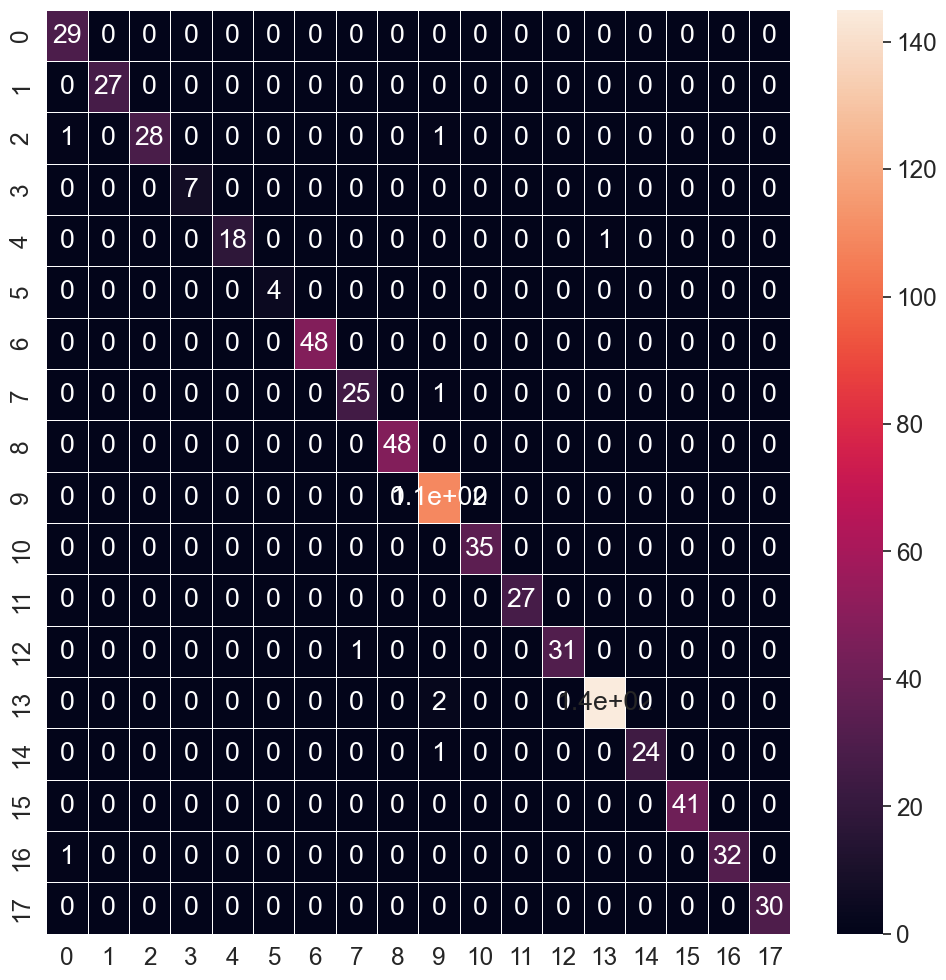

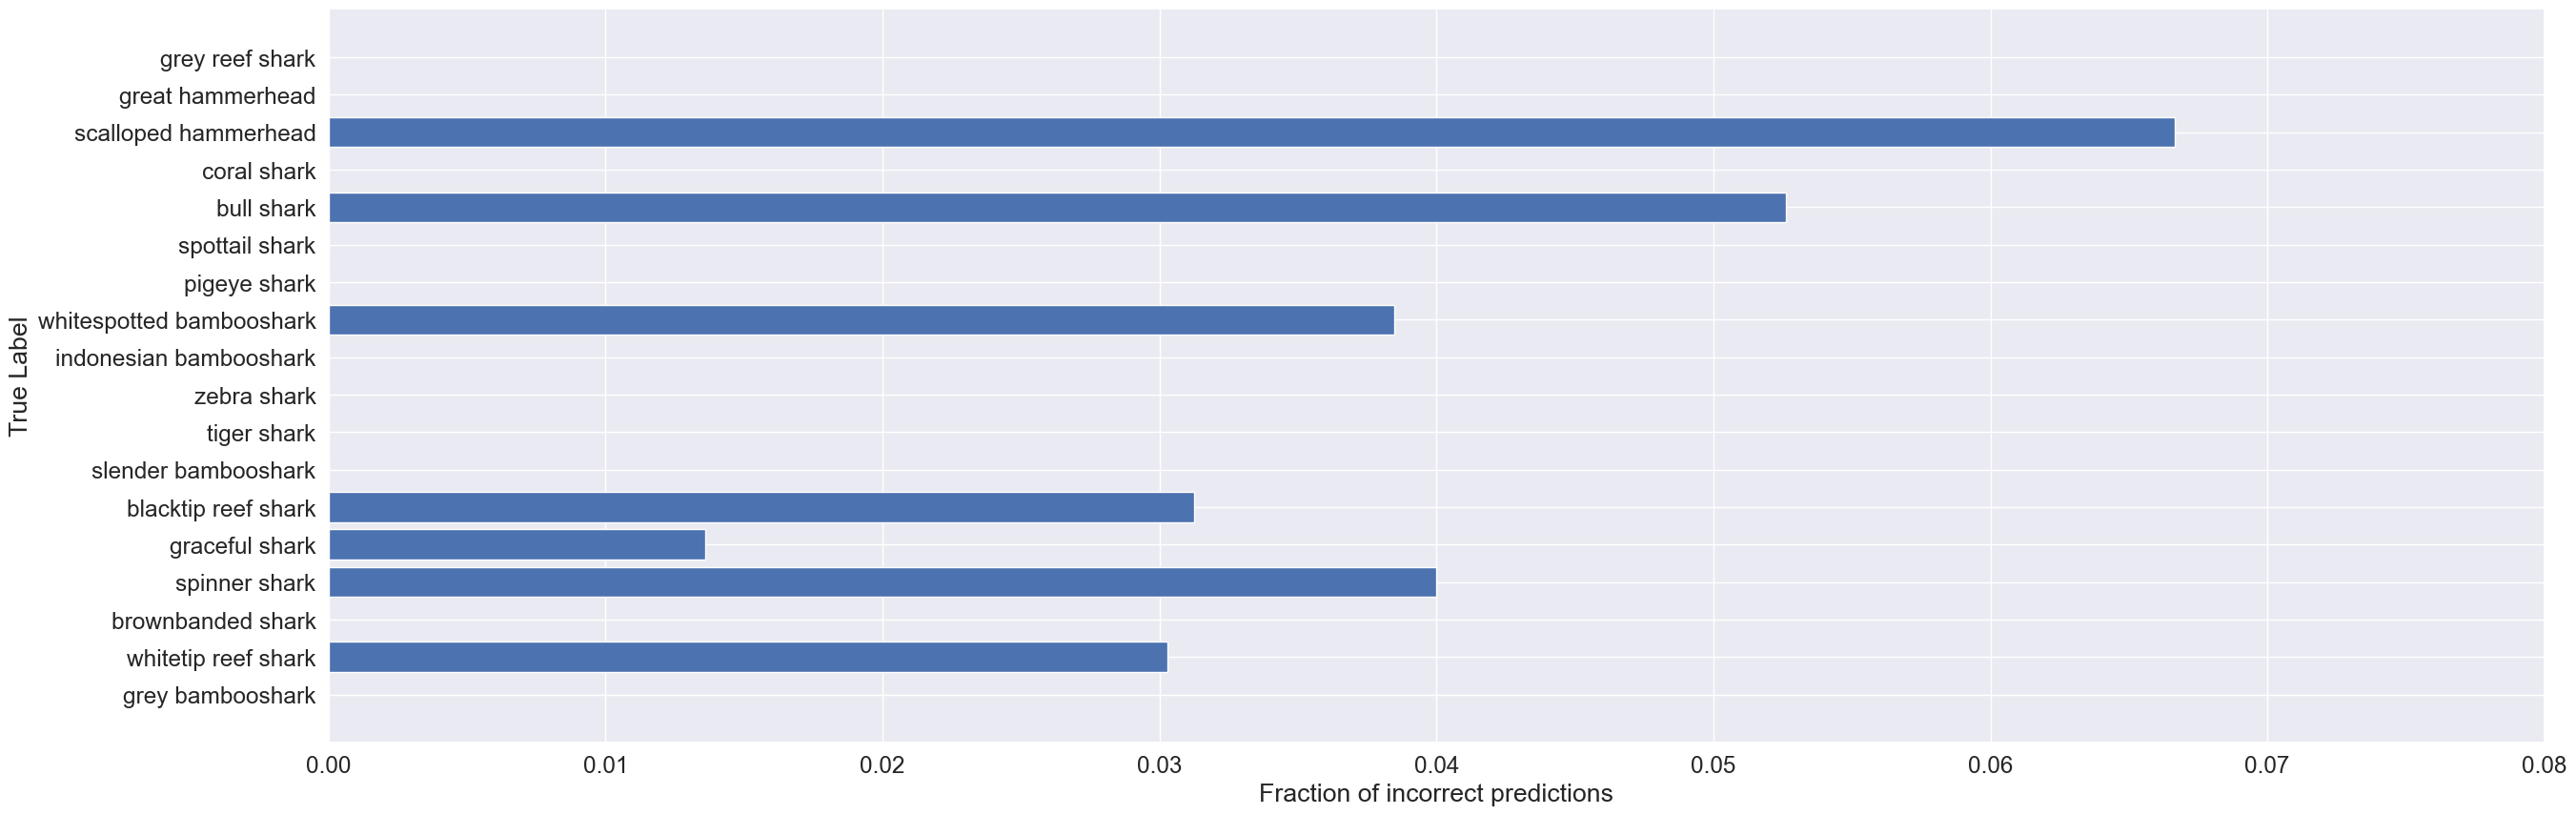

In [51]:
best_weights = [0.6, 0.2, 0.2]

ideal_weighted_preds = np.tensordot(predictions, best_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)
ideal_weighted_accuracy = accuracy_score(y_test_label, ideal_weighted_ensemble_prediction)

i = random.choice(ideal_weighted_ensemble_prediction)

print("Predicted Label: ", class_labels[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_labels[int(y_test_label[i])])

#Print confusion matrix
cm = confusion_matrix(y_test_label, ideal_weighted_ensemble_prediction)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# Calculate the fraction of incorrect predictions
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

# Create a horizontal bar graph
fig, ax = plt.subplots(figsize=(30,10))
bars = ax.barh(np.arange(18), incorr_fraction, height=0.8)

# Set the font size for the labels
plt.rcParams.update({'font.size': 20})

# Set the labels and axis limits
ax.set_xlabel('Fraction of incorrect predictions')
ax.set_ylabel('True Label')
ax.set_yticks(np.arange(18))
ax.set_yticklabels(class_labels)
ax.set_xlim([0, 0.08])

# Invert the y-axis to display the labels from top to bottom
ax.invert_yaxis()

# Save the figure
plt.savefig('../bar2.png')

# For the BOT

In [ ]:
def extract_feature_no_bg(list_images):
    data = []
    labels = []

    nb_features = 1920  
    features = np.empty((len(list_images), nb_features))

    for ind, img_path in enumerate(list_images):
        print('Processing image %s...' % (img_path))
        img = image.load_img(img_path, target_size=(299, 299))
        output1 = remove(img)
        output2 = output1.convert('RGB')
        x = image.img_to_array(output2)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features[ind,:] = np.squeeze(extractor_model.predict(x))
        labels.append(img_path.split('/')[-2])
    
    return features, labels

In [ ]:
def predict_ensemble(features):
    preds_1 = model_1.predict(features)
    sorted_preds1 = np.sort(preds_1)
    top_preds1 = sorted_preds1[0][-1:-3:-1]
    sorted_idx1 = np.argsort(preds_1)
    top_label1 = sorted_idx1[0][-1:-4:-1]
    
    preds_2 = model_2.predict(features)
    preds_prob_2 = model_2.predict_proba(features)
    sorted_preds2 = np.sort(preds_prob_2)
    top_preds2 = sorted_preds2[0][-1:-3:-1]
    sorted_idx2 = np.argsort(preds_prob_2)
    top_label2 = sorted_idx2[0][-1:-4:-1]

    preds_3 = model_3.predict(features)
    preds_prob_3 = model_3.predict_proba(features)
    sorted_preds3 = np.sort(preds_prob_3)
    top_preds3 = sorted_preds3[0][-1:-3:-1]
    sorted_idx3 = np.argsort(preds_prob_3)
    top_label3 = sorted_idx3[0][-1:-4:-1]

    # Apply the best weight values to the predicted outputs of each model
    weighted_preds_1 = preds_1 * best_weights[0]
    weighted_preds_2 = preds_2 * best_weights[1]
    weighted_preds_3 = preds_3 * best_weights[2]
    
    final_preds = np.argmax(weighted_preds_1 + weighted_preds_2 + weighted_preds_3, axis=1)
    final_preds_label = encoder_labels.inverse_transform(final_preds)
    
    print('Top 3 class for Model 1:', top_label1)
    print('Top 3 class for Model 2:', top_label2)
    print('Top 3 class for Model 3:', top_label3)
    
    print(top_preds1)
    print(top_preds2)
    print(top_preds3)
    
    if top_preds1[0] - top_preds1[1] >= 0.5 or top_preds2[0] - top_preds2[1] >= 0.5 or top_preds3[0] - top_preds3[1] >= 0.5:
        if top_preds1[0] - top_preds1[1] > 0.01 and top_preds2[0] - top_preds2[1] > 0.01 and top_preds3[0] - top_preds3[1] > 0.01:
            print('This image is', final_preds_label[0])
            return "Y", final_preds
        else:
            return "N", final_preds
    else:
        return "N", final_preds

In [ ]:
def final_answer(pred1, pred2):
    if pred1 == pred2:
        p1 = encoder_labels.inverse_transform(pred1)[0]
        return p1
    else:
        p1 = encoder_labels.inverse_transform(pred1)[0]
        p2 = encoder_labels.inverse_transform(pred2)[0]
        return p1,p2

In [ ]:
image_path = ['../dataset/test.jpg']
features, labels = extract_feature(image_path)
img_pred_class1 = predict_ensemble(features)


features2, labels2 = extract_feature_no_bg(image_path)
img_pred_class2 = predict_ensemble(features2)

print(encoder_labels.inverse_transform(img_pred_class1[1]))
print(encoder_labels.inverse_transform(img_pred_class2[1]))

if img_pred_class2[0] == "N" and img_pred_class1[0] == "N":
    print("Can you use Diffrenet Images")
    
elif img_pred_class2[0] == "Y" and img_pred_class1[0] == "N":
    print("Can you use Diffrenet Images")
    
else:
    x = final_answer(img_pred_class1[1], img_pred_class2[1])
    print(x)
    exit()

## GRAVEYARD

In [ ]:
# encoder_labels.inverse_transform([img_pred_class])

In [26]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1918, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 959, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 957, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 478, 32)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 15296)             0         
                                                                 
 dense_16 (Dense)            (None, 256)              

In [27]:
model_2.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [28]:
model_3.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
def predict_ensemble(features):
    preds_1 = model_1.predict(features)
    sorted_preds1 = np.sort(preds_1)
    top_preds1 = sorted_preds1[0][-1:-3:-1]
    sorted_idx1 = np.argsort(preds_1)
    top_label1 = sorted_idx1[0][-1:-4:-1]

    preds_2 = model_2.predict(features)
    preds_prob_2 = model_2.predict_proba(features)
    sorted_preds2 = np.sort(preds_prob_2)
    top_preds2 = sorted_preds2[0][-1:-3:-1]
    sorted_idx2 = np.argsort(preds_prob_2)
    top_label2 = sorted_idx2[0][-1:-4:-1]

    preds_3 = model_3.predict(features)
    preds_prob_3 = model_3.predict_proba(features)
    sorted_preds3 = np.sort(preds_prob_3)
    top_preds3 = sorted_preds3[0][-1:-3:-1]
    sorted_idx3 = np.argsort(preds_prob_3)
    top_label3 = sorted_idx3[0][-1:-4:-1]

    # Apply the best weight values to the predicted outputs of each model
    weighted_preds_1 = preds_1 * best_weights[0]
    weighted_preds_2 = preds_2 * best_weights[1]
    weighted_preds_3 = preds_3 * best_weights[2]

    final_preds = np.argmax(
        weighted_preds_1 + weighted_preds_2 + weighted_preds_3, axis=1)
    final_preds_label = encoder_labels.inverse_transform(final_preds)

    print('Top 3 class for Model 1:', top_label1)
    print('Top 3 class for Model 2:', top_label2)
    print('Top 3 class for Model 3:', top_label3)
    
    return final_preds

image_path = ['../dataset/pigeye.jpeg']
features, labels = extract_feature(image_path)
img_pred_class1 = predict_ensemble(features)

features2, labels2 = extract_feature_no_bg(image_path)
img_pred_class2 = predict_ensemble(features2)

x = final_answer(img_pred_class1, img_pred_class2)

In [5]:
# import numpy as np

# # example predictions from an ensemble of three models
# predictions_1 = np.array([
#     [3.2202927e-08, 1.5315185e-04, 1.7233757e-05, 7.1772654e-04, 1.4332510e-09,
#      1.2757578e-08, 8.1395841e-01, 6.3586542e-10, 1.1227312e-03, 1.7537707e-06,
#      1.6013291e-02, 5.4121660e-03, 3.5345099e-10, 1.4633089e-05, 4.4357598e-08,
#      3.7397385e-05, 2.1669805e-02, 1.4088163e-01],  # high confidence in class 1
#     [6.3199809e-06, 4.6315845e-03, 4.9378952e-05, 1.2022780e-03, 6.3356224e-06,
#      3.8227426e-09, 1.5475784e-02, 2.6750687e-04, 1.2757650e-06, 8.6600101e-03,
#      2.3523346e-06, 2.2466448e-03, 6.1496862e-06, 2.3313146e-04, 8.8369258e-02,
#      1.5762758e-02, 1.5383508e-05, 8.6306381e-01],  # low confidence, ambiguous between classes 1 and 2
#     [2.6639888e-14, 2.9453403e-01, 6.6856344e-08, 1.9082826e-08, 8.6846464e-14,
#      3.1282932e-15, 5.5196031e-10, 3.5994033e-10, 1.0120440e-12, 5.6281590e-07,
#      1.3845687e-06, 1.3462129e-06, 1.2783544e-10, 7.0477515e-01, 1.7041209e-06,
#      1.5026670e-08, 6.6973835e-06, 6.7907828e-04]   # high confidence in class 3
# ])

# predictions_2 = np.array([[0.00472216, 0.04286923, 0.00635049, 0.01075456, 0.00671726, 0.00220195, 0.30418673, 0.01024336, 0.04376968, 0.01196055, 0.03956266, 0.02746085, 0.00484341, 0.01488163, 0.00262809, 0.00818419, 0.02733589, 0.43132733],
#                           [0.02406468, 0.20427703, 0.01697068, 0.00700091, 0.01041615, 0.00294866, 0.05073226, 0.03046698, 0.00537757, 0.03641033, 0.01017061, 0.11029632, 0.01472612, 0.09311162, 0.11664034, 0.02498046, 0.01413503, 0.22727426],
#                           [0.00551298, 0.24082214, 0.00884819, 0.00662463, 0.00352115, 0.00163321, 0.03072552, 0.00944128, 0.00600155, 0.02333548, 0.01483245, 0.02374047, 0.01580032, 0.50022051, 0.01344955, 0.00691327, 0.01799971, 0.07057761]])

# predictions_3 = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
#                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
#                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


# print(predictions_1.shape)
# print(predictions_2.shape)
# print(predictions_3.shape)

# # combine the predictions from the three models
# ensemble_predictions = (predictions_1 + predictions_2 + predictions_3) / 3

# # threshold for low confidence predictions
# confidence_threshold = 0.5

# # get the maximum confidence for each prediction
# max_confidence = np.max(ensemble_predictions, axis=1)

# # create a mask for low confidence predictions
# low_confidence_mask = max_confidence < confidence_threshold

# # # create a new array of predictions with low confidence predictions replaced by "unknown"
# # new_predictions = np.copy(ensemble_predictions)
# # new_predictions[low_confidence_mask] = [0] * 18  # set the scores for all classes to 0
# # new_predictions[low_confidence_mask, -1] = 1    # set the score for "unknown" to 1

# # # print the new predictions
# # print(new_predictions)

# print(max_confidence)
# print(low_confidence_mask)


(3, 18)
(3, 18)
(3, 18)
[0.52406965 0.69677936 0.40166522]
[False False  True]
